In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading in the extracted, normalized, binned spectral light curves
## from my 'Extracting the Transmission Spectra time series' notebook
tsdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/normalizedSpectralTimeSeries.npz')
times = tsdata['times']
fluxes = tsdata['fluxes']
errors = tsdata['errors']
waves = tsdata['wavelengths']
orbit_ends = np.array([17, 34, 51])

In [3]:
print('array shape')
print('(times, wavelengths)')
print(fluxes.shape)
Npoints = fluxes.shape[0]
Nwaves = fluxes.shape[1]

array shape
(times, wavelengths)
(51, 15)


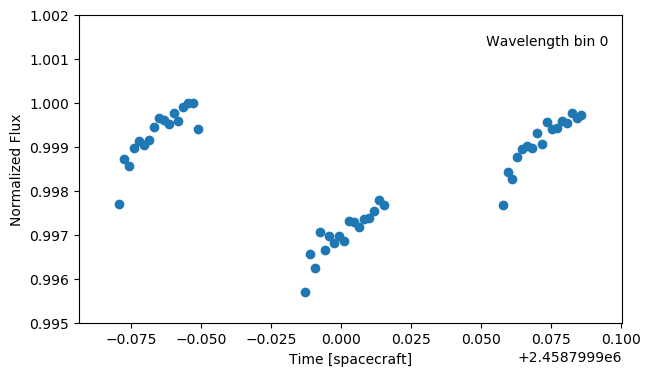

In [4]:
## plotting an example spectral light curve
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(times, fluxes[:,0])
ax.set(xlabel='Time [spacecraft]', ylabel='Normalized Flux', ylim=(0.995, 1.002))
ax.text(0.75, 0.9, 'Wavelength bin 0', transform=ax.transAxes)
plt.show()

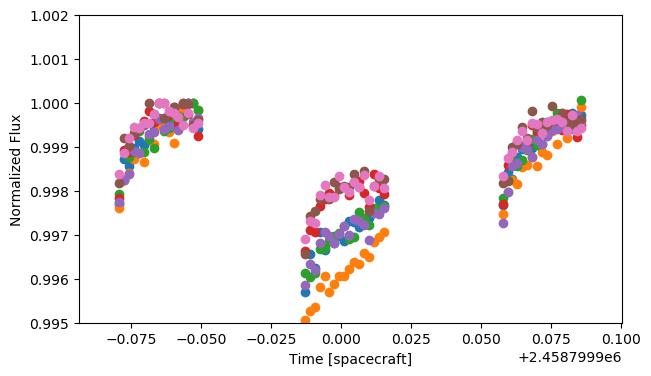

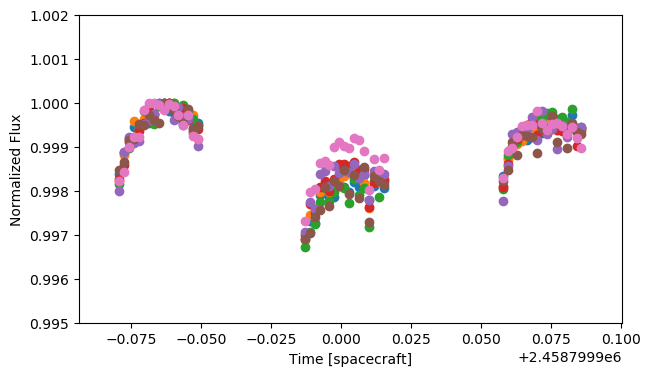

In [5]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(times, fluxes[:,0])
ax.scatter(times, fluxes[:,1])
ax.scatter(times, fluxes[:,2])
ax.scatter(times, fluxes[:,3])
ax.scatter(times, fluxes[:,4])
ax.scatter(times, fluxes[:,5])
ax.scatter(times, fluxes[:,6])
ax.set(xlabel='Time [spacecraft]', ylabel='Normalized Flux', ylim=(0.995, 1.002))
#ax.text(0.75, 0.9, 'Wavelength bin 0', transform=ax.transAxes)
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(times, fluxes[:,6])
ax.scatter(times, fluxes[:,7])
ax.scatter(times, fluxes[:,8])
ax.scatter(times, fluxes[:,9])
ax.scatter(times, fluxes[:,10])
ax.scatter(times, fluxes[:,11])
ax.scatter(times, fluxes[:,12])
ax.set(xlabel='Time [spacecraft]', ylabel='Normalized Flux', ylim=(0.995, 1.002))
#ax.text(0.75, 0.9, 'Wavelength bin 0', transform=ax.transAxes)
plt.show()

In [7]:
##
# Defining my parameter arrays (inits, priors, etc)
#
# General Structure:
# 0 = tc
# 1 = log10P
# 2 = log10(a/Rstar)
# 3 = cos(i)
# 4 = Rp / Rstar
# 5 = hook model amplitude
# 6 = hook model time-scale

labels = np.asarray(['RpRs', 'amp1', 'tau1', 'slope', 'intcpt'])#, 'tau2', 'tau3', 'slope', 'intcpt'])
# Priors
lit_tc, lit_tc_unc = 2458329.201967, 0.0012   # [day; bjd tdb]
lit_P, lit_P_unc = 6.034460, 0.000011       # [day]
lit_rprs, lit_rprs_unc = 0.04192, 0.00083   # [Rstar]
lit_a, lit_a_unc = 13.27, 0.39              # [Rstar]
lit_i, lit_i_unc = 86.38, 0.15              # [degrees]
lit_Rp = 4.71          # [Rearth]
lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]

theta_init = np.asarray([
    # Planetary parameters
    lit_rprs,                      # 4 - HST radius
    # HST systematic parameters
    3.e-3,                      # 5 - hook amplitude for orbit 2
    3.e-3,                      # 6 - hook amplitude for orbit 3
#     3.e-3,                      # 7 - hook amplitude for orbit 4
#     5.e-3,                      # 8 - hook timescale for orbit 2
#     5.e-3,                      # 9 - hook timescale for orbit 3
#     5.e-3,                       # 10 - hook timescale for orbit 4
    0.002,                      # 11 - slope for visit-long ramp
    1.0                        # 12 - intercept for visit-long ramp
])

priors = np.asarray([
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    # HST systematic parameters
    np.inf,                      # 5 - hook amplitude
    np.inf,                      # 6
    np.inf,
    np.inf,                      # 8 - hook timescales
#     np.inf,
#     np.inf,                       # 10 
#     np.inf,
#     np.inf                        # 12
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Planetary parameters
    lit_rprs_unc,                                         # 4 - HST radius
    # HST systematic parameters
    1.e-4,                                            # 5 - orbit 3&4 hook amplitude
    1.e-4,                                             # 6 - orbit 3&4 hook timescale
    1.e-4,                                               # 7
    1.e-4,                                             # 8
#     1.e-4,                                # 9
#     1.e-4,                                # 10
#     1.e-3,
#     1.e-5                                  # 12
])

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = 2458329.201974941      
InitParams.per = 6.03447168385
InitParams.a = 13.4136
InitParams.inc = 86.4225
InitParams.rp = theta_init[0]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.33, 0.2]
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [8]:
##
# Defining my astrophysical models

def transit(theta, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = 2458329.2019677      # time of conjunction [days]
    #log10P = theta[1]   # log10( Period [days] )
    #log10a = theta[2]   # log10( a / Rstar )
    #cosi = theta[3]     # cosine(inclination [rad])
    rprstar = theta[0]
        
    # Transform input parameters to forms used by BATMAN
    P = 6.0344717889069  # compute Period in [day]
    a = 13.355  # compute a/Rstar
    inc =  86.423  # Compute inclination in [deg]
    ecc = 0.    # use these if assuming circular orbit
    omega = 90.
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = [0.33, 0.2]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve


##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude_o2 = theta[1]
#     amplitude_o3 = theta[2]
#     amplitude_o4 = theta[3]
    
    tau_o2 = theta[2]
#     tau_o3 = theta[5]
#     tau_o4 = theta[6]
    
    # Pull out times [in day; MJD] of each orbit
    orbit2times = times[:orbit_ends[0]]
    orbit3times = times[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times[orbit_ends[1] : orbit_ends[2]]
    
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    
    orbit2hook = 1.0 - amplitude_o2*np.exp(- tinorbit2 / tau_o2)
    orbit3hook = 1.0 - amplitude_o2*np.exp(- tinorbit3 / tau_o2)
    orbit4hook = 1.0 - amplitude_o2*np.exp(- tinorbit4 / tau_o2)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve

def ramp(theta):
    slope = theta[3]
    intcpt = theta[4]
    
    t_new = times - np.median(times)
    y = slope*t_new + intcpt
    return y

In [9]:
def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
#     if not (0.04 <= theta[0] <= 0.05):
#         return -np.inf
#     if (theta[2] > 0.003):
#         return -np.inf
#     if (theta[5] > 0.003):
#         return -np.inf
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

def lnPosterior(theta, flux_array, unc_array):
    
    prior_array = priors
    priorerrs_array = priorserr
    #flux_array = fluxes
    #unc_array = errors
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    HSTtransit = transit(theta, BATMAN_initmodel)
    HSThook = hook(theta)
    HSTramp = ramp(theta)
    model = HSTtransit * HSThook * HSTramp

    # Compute likelihoods
    lnLikelihood = logLikelihood(flux_array, unc_array, model)

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

In [10]:
def run_mcmc(flux_array, errors_array, Nsteps=20000, previous_fits=None, previous_errs=None, returnSamples=False):
    ### Inputs:
    ## flux_array = array of fluxes, which is the data to be modeling
    ## errors_array = array of errors associated with the flux array
    ## previous_fits = array of values from a previous run, which can be used as the initial state of new run
    ## previous_errs = array of uncertainties associated with previous_fits, used in the walker initialization
    ## returnSamples = toggle to return the full MCMC sampling chains, rather than just the fits
    
    ######################################
    # Setting up and initializing MCMC

    Ndimensions = len(theta_init)
    Nwalkers = 3*Ndimensions

    # Initializing walker positions
    pos = np.zeros((Nwalkers, Ndimensions))

    if isinstance(previous_fits, type(None)):
        for i in range(Ndimensions):
            pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
        print('initialized from scratch')
    elif not isinstance(previous_fits, type(None)):
         for i in range(Ndimensions):
            pos[:,i] = previous_fits[i] + 0.5*np.random.normal(0., previous_errs[i], Nwalkers)
    
    # Running the MCMC
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool,
                                args=(flux_array, errors_array))
        sampler.run_mcmc(pos, Nsteps, progress=True);
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)
    loglikelihoods = sampler.get_log_prob(flat=True)
    #autocorrtimes = sampler.get_autocorr_time()
    
    burn = 1000
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]
    loglikelihoods = loglikelihoods[burn*Nwalkers:]

    param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
    param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])
    
    if returnSamples:
        return samples, flatsamples, loglikelihoods#, autocorrtimes
    else:
        return param_fits, param_uperrs, param_loerrs
        
        
def genModel(theta):
    gentransit = transit(theta, BATMAN_initmodel)
    genhook = hook(theta)
    genramp = ramp(theta)
    genmodel = gentransit * genhook * genramp
    return genmodel

In [16]:
for wav in range(Nwaves):
#     if (wav != 2):
#         continue
        
    #testflux = np.copy(fluxes[:,wav])
    #testflux[16] = fluxes[16, 0]
    
    print('on wavelength bin %d'%(wav))
    print('running burn-in step')
    fitsburn, uperrsburn, loerrsburn = run_mcmc(fluxes[:,wav], errors[:,wav], Nsteps=20000)
    #fitsburn, uperrsburn, loerrsburn = run_mcmc(testflux, errors[:,wav], Nsteps=20000)
    mederrsburn = np.median([uperrsburn, loerrsburn], axis=0)
    print('running MCMC')
    fits, uperrs, loerrs = run_mcmc(fluxes[:,wav], errors[:,wav], Nsteps=40000, previous_fits=fitsburn, previous_errs=mederrsburn)
    #fits, uperrs, loerrs = run_mcmc(testflux, errors[:,wav], Nsteps=30000, previous_fits=fitsburn, previous_errs=mederrsburn)
    if wav==0:
        fits0, uperrs0, loerrs0 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)
    elif wav==1:
        fits1, uperrs1, loerrs1 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)
    elif wav==2:
        fits2, uperrs2, loerrs2 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)        
    elif wav==3:
        fits3, uperrs3, loerrs3 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)    
    elif wav==4:
        fits4, uperrs4, loerrs4 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)        
    elif wav==5:
        fits5, uperrs5, loerrs5 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)   
    elif wav==6:
        fits6, uperrs6, loerrs6 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)
    elif wav==7:
        fits7, uperrs7, loerrs7 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)
    elif wav==8:
        fits8, uperrs8, loerrs8 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)
    elif wav==9:
        fits9, uperrs9, loerrs9 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)   
    elif wav==10:
        fits10, uperrs10, loerrs10 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)
    elif wav==11:
        fits11, uperrs11, loerrs11 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)
    elif wav==12:
        fits12, uperrs12, loerrs12 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)        
    elif wav==13:
        fits13, uperrs13, loerrs13 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)        
    elif wav==14:
        fits14, uperrs14, loerrs14 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)        
    elif wav==15:
        fits15, uperrs15, loerrs15 = np.copy(fits), np.copy(uperrs), np.copy(loerrs)                
        

on wavelength bin 0
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 618.41it/s]

running MCMC



100%|██████████| 40000/40000 [01:05<00:00, 606.97it/s]


on wavelength bin 1
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:33<00:00, 599.01it/s]

running MCMC



100%|██████████| 40000/40000 [01:06<00:00, 602.35it/s]


on wavelength bin 2
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 612.44it/s]

running MCMC



100%|██████████| 40000/40000 [01:05<00:00, 609.28it/s]


on wavelength bin 3
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:33<00:00, 594.21it/s]

running MCMC



100%|██████████| 40000/40000 [01:05<00:00, 615.05it/s]


on wavelength bin 4
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:33<00:00, 600.35it/s]

running MCMC



100%|██████████| 40000/40000 [01:05<00:00, 610.13it/s]

on wavelength bin 5
running burn-in step
initialized from scratch



100%|██████████| 20000/20000 [00:32<00:00, 609.90it/s]


running MCMC


100%|██████████| 40000/40000 [01:05<00:00, 609.61it/s]


on wavelength bin 6
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 611.71it/s]

running MCMC



100%|██████████| 40000/40000 [01:05<00:00, 606.20it/s]


on wavelength bin 7
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:33<00:00, 599.95it/s]

running MCMC



100%|██████████| 40000/40000 [01:05<00:00, 609.72it/s]


on wavelength bin 8
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 608.43it/s]

running MCMC



100%|██████████| 40000/40000 [01:05<00:00, 613.44it/s]


on wavelength bin 9
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 607.58it/s]


running MCMC


100%|██████████| 40000/40000 [01:05<00:00, 611.58it/s]


on wavelength bin 10
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:33<00:00, 598.48it/s]

running MCMC



100%|██████████| 40000/40000 [01:04<00:00, 621.84it/s]


on wavelength bin 11
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 621.01it/s]

running MCMC



100%|██████████| 40000/40000 [01:04<00:00, 624.11it/s]


on wavelength bin 12
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 621.63it/s]


running MCMC


100%|██████████| 40000/40000 [01:05<00:00, 609.05it/s]


on wavelength bin 13
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:33<00:00, 595.83it/s]

running MCMC



100%|██████████| 40000/40000 [01:04<00:00, 617.18it/s]


on wavelength bin 14
running burn-in step
initialized from scratch


100%|██████████| 20000/20000 [00:32<00:00, 614.44it/s]


running MCMC


100%|██████████| 40000/40000 [01:05<00:00, 611.38it/s]


Fitted Rp/Rs values
bin 0: 0.0489 +/- 0.0001 
bin 2: 0.0492 +/- 0.0001 


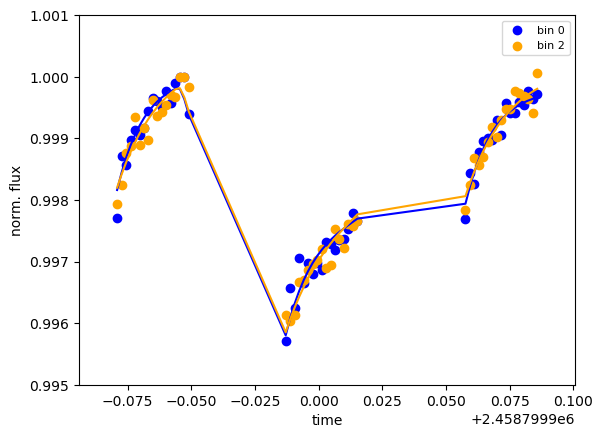

In [17]:
print('Fitted Rp/Rs values')
print('bin 0: %.4f +/- %.4f '%(fits0[0], uperrs0[0]))
print('bin 2: %.4f +/- %.4f '%(fits2[0], uperrs2[0]))
plt.scatter(times, fluxes[:,0], c='blue', label='bin 0')
plt.plot(times, genModel(fits0), c='blue')
# plt.plot(times, transit(fits0, BATMAN_initmodel), c='blue')
# plt.plot(times, hook(fits0), c='blue')
plt.scatter(times, fluxes[:,2], label='bin 2', c='orange')
# plt.scatter(times, testflux, label='bin 2 test', c='orange')
plt.plot(times, genModel(fits2), c='orange')
# #plt.plot(times, transit(fits2, BATMAN_initmodel), c='orange')
# test2 = np.copy(fits2)
# #test2[2] = fits0[2]
# test2[5] = fits0[5]
# plt.plot(times, hook(test2), c='orange')
plt.ylim((0.995, 1.001))
plt.xlabel('time')
plt.ylabel('norm. flux')
plt.legend(loc='best', fontsize=8)
plt.show()

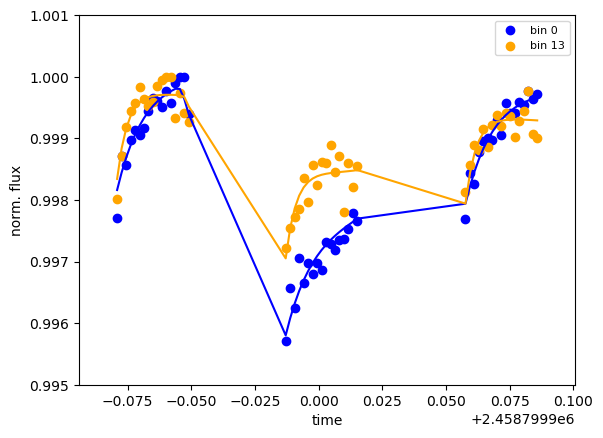

In [33]:
# print('Fitted Rp/Rs values')
# print('bin 0: %.4f +/- %.4f '%(fits0[0], uperrs0[0]))
# print('bin 2: %.4f +/- %.4f '%(fits2[0], uperrs2[0]))
plt.scatter(times, fluxes[:,0], c='blue', label='bin 0')
plt.plot(times, genModel(fits0), c='blue')
plt.scatter(times, fluxes[:,13], label='bin 13', c='orange')
plt.plot(times, genModel(fits13), c='orange')
plt.ylim((0.995, 1.001))
plt.xlabel('time')
plt.ylabel('norm. flux')
plt.legend(loc='best', fontsize=8)
plt.show()

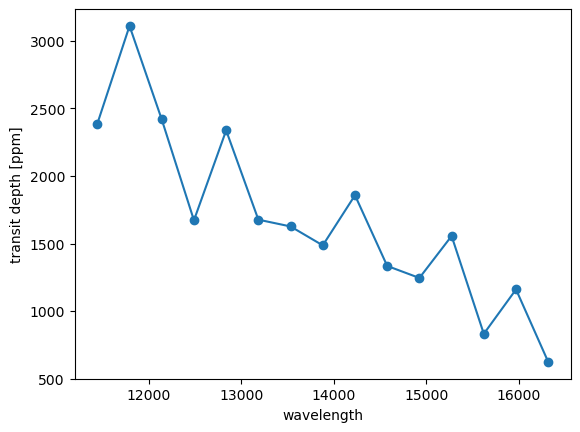

In [49]:
rprs_fits = np.array([fits0[0], fits1[0], fits2[0], fits3[0], fits4[0], fits5[0],
                     fits6[0], fits7[0], fits8[0], fits9[0], fits10[0], fits11[0],
                     fits12[0], fits13[0], fits14[0]])
rprs_uperrs = np.array([uperrs0[0], uperrs1[0], uperrs2[0], uperrs3[0], uperrs4[0], uperrs5[0],
                     uperrs6[0], uperrs7[0], uperrs8[0], uperrs9[0], uperrs10[0], uperrs11[0],
                     uperrs12[0], uperrs13[0], uperrs14[0]])

depths = rprs_fits**2
depths_errs = 2.*depths*(rprs_uperrs/rprs_fits)

plt.plot(waves, depths*1.e6, marker='o')
plt.xlabel('wavelength')
plt.ylabel('transit depth [ppm]')
#plt.plot(waves, rprs_fits, marker='o')
plt.show()

In [51]:
depths_errs*1.e6

array([5.895699  , 6.95433957, 6.74285033, 5.45557823, 6.67789678,
       6.585803  , 6.58985934, 5.51594277, 6.72683906, 6.88254813,
       6.96247706, 5.77956712, 7.31999364, 7.45417483, 7.68823936])

In [46]:
(rprs_uperrs/rprs_fits)*1.e6

array([1235.13220869, 1117.74938322, 1393.90146107, 1631.45574383,
       1428.49901688, 1963.95075246, 2025.80598236, 1855.52658581,
       1810.75885696, 2579.36054318, 2795.68585259, 1857.33447452,
       4400.91135949, 3212.14225551, 6163.65163377])

In [48]:
depths

array([0.00238667, 0.00311087, 0.0024187 , 0.001672  , 0.00233738,
       0.00167667, 0.00162648, 0.00148636, 0.00185746, 0.00133416,
       0.00124522, 0.00155588, 0.00083165, 0.00116031, 0.00062368])

In [47]:
2.*depths*(rprs_uperrs/rprs_fits)*1.e6

array([5.895699  , 6.95433957, 6.74285033, 5.45557823, 6.67789678,
       6.585803  , 6.58985934, 5.51594277, 6.72683906, 6.88254813,
       6.96247706, 5.77956712, 7.31999364, 7.45417483, 7.68823936])

In [ ]:
rprs_uperrs = np.array([uperrs0[0], uperrs1[0], uperrs2[0], uperrs3[0], uperrs4[0], uperrs5[0],
                     uperrs6[0], uperrs7[0], uperrs8[0], uperrs9[0], uperrs10[0], uperrs11[0],
                     uperrs12[0], uperrs13[0], uperrs14[0]])

In [ ]:
print('    bin 0    bin2')
for val in range(fits0.shape[0]):
    print('%d  %.4f    %.4f      %s'%(val, fits0[val], fits2[val], labels[val]))